<a href="https://colab.research.google.com/github/koushikroy/facial_sentiment_analysis/blob/main/00_sentiment_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [7]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Dateset Loading and Preprocessing

## Downloading Dataset

In [8]:
!wget https://raw.githubusercontent.com/koushikroy/facial_sentiment_analysis/main/dataset/dataset_sentiment_face_landmarks.csv

--2021-07-03 12:20:36--  https://raw.githubusercontent.com/koushikroy/facial_sentiment_analysis/main/dataset/dataset_sentiment_face_landmarks.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16276236 (16M) [text/plain]
Saving to: ‘dataset_sentiment_face_landmarks.csv.1’

dataset_sentiment_f 100%[===================>]  15.52M  75.8MB/s    in 0.2s    

2021-07-03 12:20:36 (75.8 MB/s) - ‘dataset_sentiment_face_landmarks.csv.1’ saved [16276236/16276236]



## Exploring and Cleaning 

In [9]:
sentiment_data_original = pd.read_csv('/content/dataset_sentiment_face_landmarks.csv')

In [10]:
sentiment_data_original.head(10)

,Unnamed: 0,1x,1y,2x,2y,3x,3y,4x,4y,5x,5y,6x,6y,7x,7y,8x,8y,9x,9y,10x,10y,11x,11y,12x,12y,13x,13y,14x,14y,15x,15y,16x,16y,17x,17y,18x,18y,19x,19y,20x,...,449y,450x,450y,451x,451y,452x,452y,453x,453y,454x,454y,455x,455y,456x,456y,457x,457y,458x,458y,459x,459y,460x,460y,461x,461y,462x,462y,463x,463y,464x,464y,465x,465y,466x,466y,467x,467y,468x,468y,output
0,0,0.471114,0.646392,0.462975,0.552659,0.466726,0.578822,0.434750,0.439725,0.461484,0.519575,0.460532,0.473270,0.459655,0.360723,0.248363,0.351089,0.458165,0.284641,0.456921,0.243084,0.453431,0.087810,0.471981,0.660933,0.472802,0.670488,0.473516,0.673532,0.474548,0.675410,0.475064,0.686886,0.475771,0.701211,0.476646,0.716253,0.477596,0.741880,0.464268,...,0.382331,0.667334,0.392538,0.626921,0.392877,0.588903,0.386264,0.560101,0.377370,0.539828,0.368396,0.807646,0.402829,0.552347,0.549719,0.511613,0.450629,0.511133,0.544056,0.495620,0.558106,0.511510,0.547564,0.544053,0.558156,0.490060,0.562254,0.487931,0.566759,0.541290,0.343106,0.523212,0.352673,0.513798,0.359954,0.684050,0.326306,0.698897,0.316221,anger
1,1,0.530374,0.614034,0.531349,0.512339,0.528999,0.540964,0.500500,0.413760,0.531190,0.482696,0.529466,0.442167,0.523717,0.344421,0.297536,0.342679,0.521402,0.290264,0.520840,0.254662,0.514536,0.098683,0.530600,0.628268,0.530085,0.637578,0.529426,0.640497,0.529368,0.639768,0.529859,0.650274,0.530190,0.664070,0.529899,0.679439,0.528366,0.710455,0.530667,...,0.368076,0.722751,0.377521,0.682221,0.377576,0.643719,0.370850,0.614945,0.362032,0.595026,0.353581,0.855087,0.397170,0.612071,0.514794,0.575969,0.423784,0.577334,0.503919,0.559598,0.517776,0.575699,0.507627,0.602376,0.523786,0.555060,0.521378,0.551001,0.526814,0.597014,0.330898,0.579347,0.339900,0.571792,0.346182,0.738742,0.315066,0.753040,0.309837,anger
2,2,0.499339,0.608413,0.493128,0.508219,0.495579,0.535847,0.464834,0.407602,0.491925,0.478106,0.490625,0.437034,0.488284,0.336501,0.285974,0.332120,0.486582,0.272432,0.485704,0.234519,0.481379,0.085394,0.500151,0.622561,0.500575,0.631630,0.500789,0.634012,0.500746,0.637065,0.501155,0.647303,0.501701,0.660387,0.502103,0.674604,0.502113,0.700330,0.493903,...,0.361170,0.686117,0.370573,0.647025,0.371127,0.609848,0.364684,0.581429,0.355766,0.561706,0.347007,0.825761,0.385894,0.581577,0.509742,0.539283,0.418160,0.540178,0.500309,0.524545,0.514125,0.540220,0.503983,0.573293,0.518513,0.519078,0.517668,0.516920,0.522851,0.562427,0.324119,0.546049,0.332307,0.538086,0.338227,0.697591,0.309795,0.712155,0.301570,anger
3,3,0.529479,0.596424,0.518820,0.487511,0.522396,0.519907,0.485652,0.392520,0.515976,0.457292,0.512458,0.418244,0.504405,0.323978,0.303410,0.329820,0.498773,0.258971,0.495628,0.220827,0.483342,0.075667,0.530859,0.611838,0.531853,0.622986,0.532254,0.627294,0.533231,0.636364,0.534426,0.649277,0.535938,0.665309,0.537417,0.682307,0.539387,0.708519,0.520398,...,0.346405,0.700638,0.357059,0.662449,0.359155,0.625250,0.354061,0.596125,0.345545,0.575908,0.336774,0.835300,0.377961,0.599364,0.493469,0.557649,0.401755,0.561685,0.478897,0.547105,0.494426,0.561347,0.483553,0.591593,0.503534,0.542726,0.497738,0.540497,0.504409,0.574548,0.313745,0.559276,0.321806,0.552033,0.326915,0.708733,0.290693,0.722408,0.281697,anger
4,4,0.525898,0.594125,0.530033,0.520760,0.526494,0.539220,0.501730,0.428694,0.529735,0.494154,0.527859,0.456417,0.521891,0.362743,0.314410,0.347706,0.519482,0.305851,0.518616,0.271582,0.510917,0.113934,0.525877,0.606459,0.525577,0.614201,0.525121,0.615786,0.525468,0.621487,0.526047,0.632069,0.526596,0.645588,0.526815,0.660449,0.527288,0.689682,0.529146,...,0.367748,0.702343,0.378468,0.665439,0.381132,0.630534,0.377438,0.604434,0.371070,0.586778,0.364706,0.819888,0.379130,0.605477,0.512631,0.570194,0.435722,0.571645,0.512119,0.555648,0.523526,0.570675,0.514408,0.597486,0.519641,0.551468,0.527428,0.547463,0.530250,0.587661,0.344591,0.572917,0.352940,0.566291,0.359595,0.716786,0.320512,0.729813,0.313735,anger
5,5,0.519534,0.615290,0.515736,0.522739,0.516086,0.545503,0.4865


**From the dataset, we can see that:**
*   There are in total 937 Columns excluding the index column 
*   The first 936 columns represents the landmark points in the face and the 'output' column represnts the emotion
*   The face has been cropped and resized thus no need for further normalization



In [11]:
sentiment_data_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Columns: 938 entries, Unnamed: 0 to output
dtypes: float64(936), int64(1), object(1)
memory usage: 6.6+ MB


In [12]:
#value_count in the output column 
sentiment_data_original['output'].value_counts()

neutral      593
surprise      83
happiness     69
disgust       59
anger         45
sadness       28
fear          25
contempt      18
Name: output, dtype: int64



> So you can see that the neutral category has a staggering number of input compared to othet categories. This can be a later as the model might be overflitted. So, we need to take care of this.



In [17]:
all_neutral = sentiment_data_original['output'] == 'neutral' 
list_of_neutral_index = []   
for i in range (len(all_neutral)):
    if all_neutral[i]:
        list_of_neutral_index.append(i)


In [19]:
# The first and last index number of neutral faces
list_of_neutral_index[0], list_of_neutral_index[-1]

(216, 808)

In [37]:
# Let's delete some of the neutral data 
sentiment_data_small_version = sentiment_data_original.drop(list(range(list_of_neutral_index[59] , list_of_neutral_index[-1])))

In [38]:
sentiment_data_small_version.head()

,Unnamed: 0,1x,1y,2x,2y,3x,3y,4x,4y,5x,5y,6x,6y,7x,7y,8x,8y,9x,9y,10x,10y,11x,11y,12x,12y,13x,13y,14x,14y,15x,15y,16x,16y,17x,17y,18x,18y,19x,19y,20x,...,449y,450x,450y,451x,451y,452x,452y,453x,453y,454x,454y,455x,455y,456x,456y,457x,457y,458x,458y,459x,459y,460x,460y,461x,461y,462x,462y,463x,463y,464x,464y,465x,465y,466x,466y,467x,467y,468x,468y,output
0,0,0.471114,0.646392,0.462975,0.552659,0.466726,0.578822,0.434750,0.439725,0.461484,0.519575,0.460532,0.473270,0.459655,0.360723,0.248363,0.351089,0.458165,0.284641,0.456921,0.243084,0.453431,0.087810,0.471981,0.660933,0.472802,0.670488,0.473516,0.673532,0.474548,0.675410,0.475064,0.686886,0.475771,0.701211,0.476646,0.716253,0.477596,0.741880,0.464268,...,0.382331,0.667334,0.392538,0.626921,0.392877,0.588903,0.386264,0.560101,0.377370,0.539828,0.368396,0.807646,0.402829,0.552347,0.549719,0.511613,0.450629,0.511133,0.544056,0.495620,0.558106,0.511510,0.547564,0.544053,0.558156,0.490060,0.562254,0.487931,0.566759,0.541290,0.343106,0.523212,0.352673,0.513798,0.359954,0.684050,0.326306,0.698897,0.316221,anger
1,1,0.530374,0.614034,0.531349,0.512339,0.528999,0.540964,0.500500,0.413760,0.531190,0.482696,0.529466,0.442167,0.523717,0.344421,0.297536,0.342679,0.521402,0.290264,0.520840,0.254662,0.514536,0.098683,0.530600,0.628268,0.530085,0.637578,0.529426,0.640497,0.529368,0.639768,0.529859,0.650274,0.530190,0.664070,0.529899,0.679439,0.528366,0.710455,0.530667,...,0.368076,0.722751,0.377521,0.682221,0.377576,0.643719,0.370850,0.614945,0.362032,0.595026,0.353581,0.855087,0.397170,0.612071,0.514794,0.575969,0.423784,0.577334,0.503919,0.559598,0.517776,0.575699,0.507627,0.602376,0.523786,0.555060,0.521378,0.551001,0.526814,0.597014,0.330898,0.579347,0.339900,0.571792,0.346182,0.738742,0.315066,0.753040,0.309837,anger
2,2,0.499339,0.608413,0.493128,0.508219,0.495579,0.535847,0.464834,0.407602,0.491925,0.478106,0.490625,0.437034,0.488284,0.336501,0.285974,0.332120,0.486582,0.272432,0.485704,0.234519,0.481379,0.085394,0.500151,0.622561,0.500575,0.631630,0.500789,0.634012,0.500746,0.637065,0.501155,0.647303,0.501701,0.660387,0.502103,0.674604,0.502113,0.700330,0.493903,...,0.361170,0.686117,0.370573,0.647025,0.371127,0.609848,0.364684,0.581429,0.355766,0.561706,0.347007,0.825761,0.385894,0.581577,0.509742,0.539283,0.418160,0.540178,0.500309,0.524545,0.514125,0.540220,0.503983,0.573293,0.518513,0.519078,0.517668,0.516920,0.522851,0.562427,0.324119,0.546049,0.332307,0.538086,0.338227,0.697591,0.309795,0.712155,0.301570,anger
3,3,0.529479,0.596424,0.518820,0.487511,0.522396,0.519907,0.485652,0.392520,0.515976,0.457292,0.512458,0.418244,0.504405,0.323978,0.303410,0.329820,0.498773,0.258971,0.495628,0.220827,0.483342,0.075667,0.530859,0.611838,0.531853,0.622986,0.532254,0.627294,0.533231,0.636364,0.534426,0.649277,0.535938,0.665309,0.537417,0.682307,0.539387,0.708519,0.520398,...,0.346405,0.700638,0.357059,0.662449,0.359155,0.625250,0.354061,0.596125,0.345545,0.575908,0.336774,0.835300,0.377961,0.599364,0.493469,0.557649,0.401755,0.561685,0.478897,0.547105,0.494426,0.561347,0.483553,0.591593,0.503534,0.542726,0.497738,0.540497,0.504409,0.574548,0.313745,0.559276,0.321806,0.552033,0.326915,0.708733,0.290693,0.722408,0.281697,anger
4,4,0.525898,0.594125,0.530033,0.520760,0.526494,0.539220,0.501730,0.428694,0.529735,0.494154,0.527859,0.456417,0.521891,0.362743,0.314410,0.347706,0.519482,0.305851,0.518616,0.271582,0.510917,0.113934,0.525877,0.606459,0.525577,0.614201,0.525121,0.615786,0.525468,0.621487,0.526047,0.632069,0.526596,0.645588,0.526815,0.660449,0.527288,0.689682,0.529146,...,0.367748,0.702343,0.378468,0.665439,0.381132,0.630534,0.377438,0.604434,0.371070,0.586778,0.364706,0.819888,0.379130,0.605477,0.512631,0.570194,0.435722,0.571645,0.512119,0.555648,0.523526,0.570675,0.514408,0.597486,0.519641,0.551468,0.527428,0.547463,0.530250,0.587661,0.344591,0.572917,0.352940,0.566291,0.359595,0.716786,0.320512,0.729813,0.313735,anger


In [39]:
sentiment_data_small_version['output'].value_counts()

surprise     83
happiness    69
neutral      60
disgust      59
anger        45
sadness      28
fear         25
contempt     18
Name: output, dtype: int64

## Mapping The Output Column

In [40]:
input_df_copy = sentiment_data_small_version

In [41]:
uniqueValues = input_df_copy['output'].unique()
input_df_copy['output'] = input_df_copy['output'].map({uniqueValues[0]:0,uniqueValues[1]:1,uniqueValues[2]:2,
                                                       uniqueValues[3]:3,uniqueValues[4]:4,uniqueValues[5]:5,
                                                       uniqueValues[6]:6,uniqueValues[7]:7})

In [42]:
uniqueValues

array(['anger', 'contempt', 'disgust', 'fear', 'happiness', 'neutral',
       'sadness', 'surprise'], dtype=object)

## Train Test Split

In [43]:
# Create X & y
X = input_df_copy.drop("output", axis=1)
y = input_df_copy["output"]

# Build our train and test sets (use random state to ensure same split as before)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Declaration and Training

## Model 1

### Declaration

In [55]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(256, activation='relu'),    
    layers.Dropout(.2),
    layers.Dense(128, activation='relu'),    
    layers.Dropout(.2),
    layers.Dense(64, activation='relu'),
    layers.Dense(8, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = .0003),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
)

early_stopping = keras.callbacks.EarlyStopping(
    patience=250,
    min_delta=0.0001,
    restore_best_weights=True,
)

### Training

In [56]:
history_1 = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=2000,
    callbacks=[early_stopping],
    verbose=1, 
)

Epoch 1/2000
10/10 [==============================] - 1s 34ms/step - loss: 2.3915 - accuracy: 0.1262 - val_loss: 2.0607 - val_accuracy: 0.1538
Epoch 2/2000
10/10 [==============================] - 0s 7ms/step - loss: 1.9815 - accuracy: 0.2557 - val_loss: 1.9408 - val_accuracy: 0.1667
Epoch 3/2000
10/10 [==============================] - 0s 7ms/step - loss: 1.9516 - accuracy: 0.2330 - val_loss: 1.8987 - val_accuracy: 0.1795
Epoch 4/2000
10/10 [==============================] - 0s 7ms/step - loss: 1.9696 - accuracy: 0.2006 - val_loss: 1.9024 - val_accuracy: 0.1667
Epoch 5/2000
10/10 [==============================] - 0s 9ms/step - loss: 1.9176 - accuracy: 0.1877 - val_loss: 1.9027 - val_accuracy: 0.1538
Epoch 6/2000
10/10 [==============================] - 0s 7ms/step - loss: 1.8712 - accuracy: 0.2104 - val_loss: 1.8845 - val_accuracy: 0.2179
Epoch 7/2000
10/10 [==============================] - 0s 9ms/step - loss: 1.9088 - accuracy: 0.1942 - val_loss: 1.8873 - val_accuracy: 0.1410
Epoch

### Evaluation and Graphs

In [62]:
# Evaluate our model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Model loss on the test set: {loss}")
print(f"Model accuracy on the test set: {100*accuracy:.2f}%")

3/3 [==============================] - 0s 5ms/step - loss: 0.7197 - accuracy: 0.6795
Model loss on the test set: 0.719667375087738
Model accuracy on the test set: 67.95%


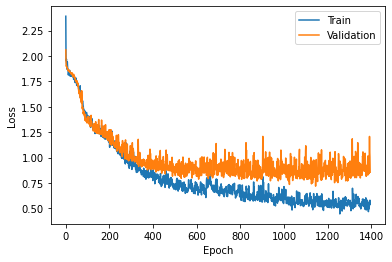

In [58]:
# summarize history for loss
plt.plot(history_1.history['loss'])#[5:])
plt.plot(history_1.history['val_loss'])#[5:])
#plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

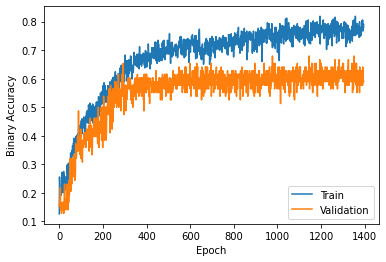

In [59]:
# summarize history for accuracy
plt.plot(history_1.history['accuracy'])#[5:])
plt.plot(history_1.history['val_accuracy'])#[5:])
#plt.title('model loss')
plt.ylabel('Binary Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

## Model 2

### Declaration

In [60]:
from tensorflow import keras
from tensorflow.keras import layers

model_2 = keras.Sequential([
    layers.Dense(512, activation='relu'),    
    layers.Dropout(.2),
    layers.Dense(256, activation='relu'),    
    layers.Dropout(.2),
    layers.Dense(128, activation='relu'),    
    layers.Dropout(.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(8, activation='softmax')
])

model_2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = .0003),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
)

early_stopping = keras.callbacks.EarlyStopping(
    patience=250,
    min_delta=0.0001,
    restore_best_weights=True,
)

### Training

In [61]:
history_2 = model_2.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=2000,
    callbacks=[early_stopping],
    verbose=1, 
)

Epoch 1/2000
10/10 [==============================] - 1s 40ms/step - loss: 2.3370 - accuracy: 0.1197 - val_loss: 2.0476 - val_accuracy: 0.1923
Epoch 2/2000
10/10 [==============================] - 0s 11ms/step - loss: 2.1680 - accuracy: 0.1521 - val_loss: 2.0481 - val_accuracy: 0.2308
Epoch 3/2000
10/10 [==============================] - 0s 13ms/step - loss: 2.0783 - accuracy: 0.1748 - val_loss: 2.0494 - val_accuracy: 0.2179
Epoch 4/2000
10/10 [==============================] - 0s 11ms/step - loss: 2.0566 - accuracy: 0.1877 - val_loss: 2.0518 - val_accuracy: 0.2179
Epoch 5/2000
10/10 [==============================] - 0s 11ms/step - loss: 2.0354 - accuracy: 0.1974 - val_loss: 2.0357 - val_accuracy: 0.2179
Epoch 6/2000
10/10 [==============================] - 0s 12ms/step - loss: 2.0093 - accuracy: 0.2136 - val_loss: 2.0471 - val_accuracy: 0.2179
Epoch 7/2000
10/10 [==============================] - 0s 12ms/step - loss: 2.0490 - accuracy: 0.1942 - val_loss: 2.0366 - val_accuracy: 0.2051

### Evaluation and Graphs

In [63]:
# Evaluate our model on the test set
loss, accuracy = model_2.evaluate(X_test, y_test)
print(f"Model loss on the test set: {loss}")
print(f"Model accuracy on the test set: {100*accuracy:.2f}%")

3/3 [==============================] - 0s 5ms/step - loss: 0.7995 - accuracy: 0.6410
Model loss on the test set: 0.7994661927223206
Model accuracy on the test set: 64.10%


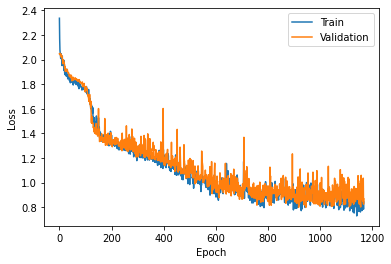

In [64]:
# summarize history for loss
plt.plot(history_2.history['loss'])#[5:])
plt.plot(history_2.history['val_loss'])#[5:])
#plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

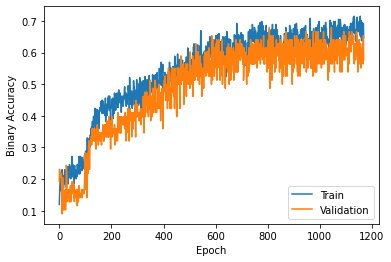

In [65]:
# summarize history for accuracy
plt.plot(history_2.history['accuracy'])#[5:])
plt.plot(history_2.history['val_accuracy'])#[5:])
#plt.title('model loss')
plt.ylabel('Binary Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()